In [2]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join, vstack
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic

import gala.coordinates as gc
import gala.dynamics as gd
from gala.units import galactic
from pyia import GaiaData

In [3]:
g = GaiaData('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits')
len(g)

397129

In [4]:
galcen = coord.Galactocentric(galcen_distance=8.1*u.kpc, z_sun=0*u.pc)

In [5]:
kop_vr = ascii.read("""phi1 phi2 vr err
-45.23 -0.04 28.8 6.9
-43.17 -0.09 29.3 10.2
-39.54 -0.07 2.9  8.7
-39.25 -0.22 -5.2 6.5
-37.95 0.00 1.1   5.6
-37.96 -0.00 -11.7 11.2
-35.49 -0.05 -50.4 5.2
-35.27 -0.02 -30.9 12.8
-34.92 -0.15 -35.3 7.5
-34.74 -0.08 -30.9 9.2
-33.74 -0.18 -74.3 9.8
-32.90 -0.15 -71.5 9.6
-32.25 -0.17 -71.5 9.2
-29.95 -0.00 -92.7 8.7
-26.61 -0.11 -114.2 7.3
-25.45 -0.14 -67.8 7.1
-24.86 0.01 -111.2 17.8
-21.21 -0.02 -144.4 10.5
-14.47 -0.15 -179.0 10.0
-13.73 -0.28 -191.4 7.5
-13.02 -0.21 -162.9 9.6
-12.68 -0.26 -217.2 10.7
-12.55 -0.23 -172.2 6.6""")

### Polygonal selections in each observable:

In [6]:
phi12_poly = np.load('../../gd1-dr2/output/phi12_poly.npy')

In [7]:
w = np.load('../../gd1-dr2/data/stream_model.npy')
stream_w = gd.PhaseSpacePosition(pos=w[:, :3].T*u.kpc,
                                 vel=w[:, 3:].T*u.km/u.s)
model_streamc = stream_w.to_coord_frame(gc.GD1, galactocentric_frame=galcen)

model_phi1 = model_streamc.phi1.wrap_at(180*u.deg)
model_mask = (model_phi1 > -100*u.deg) & (model_phi1 < 20*u.deg)

model_phi1 = model_phi1[model_mask]
model_c = stream_w[model_mask].to_coord_frame(coord.ICRS, galactocentric_frame=galcen)
model_streamc = model_streamc[model_mask]

Text(0,0.5,'$\\mu_2$')

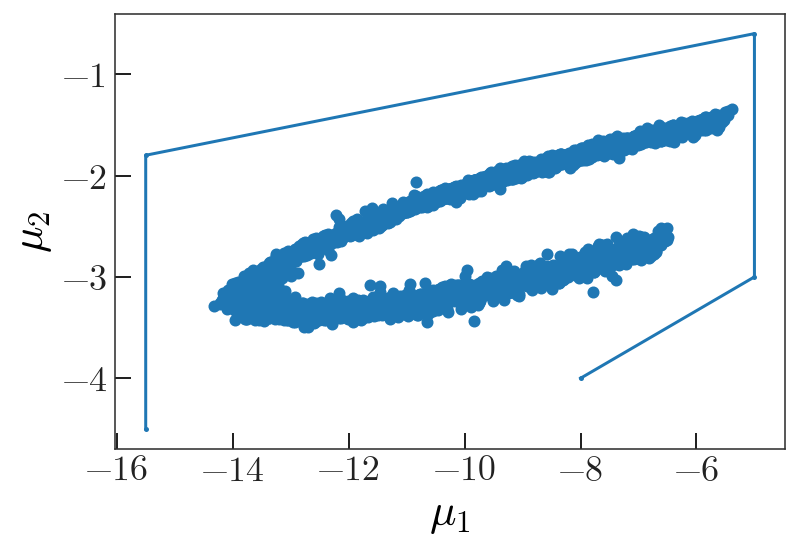

In [8]:
plt.scatter(model_streamc.pm_phi1_cosphi2, model_streamc.pm_phi2)

pm_poly = np.array([[-15.5, -4.5],
                    [-15.5, -1.8],
                    [-5, -0.6],
                    [-5, -3],
                    [-8, -4.]])

plt.plot(pm_poly[:, 0], pm_poly[:, 1])
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')

(20, 23)

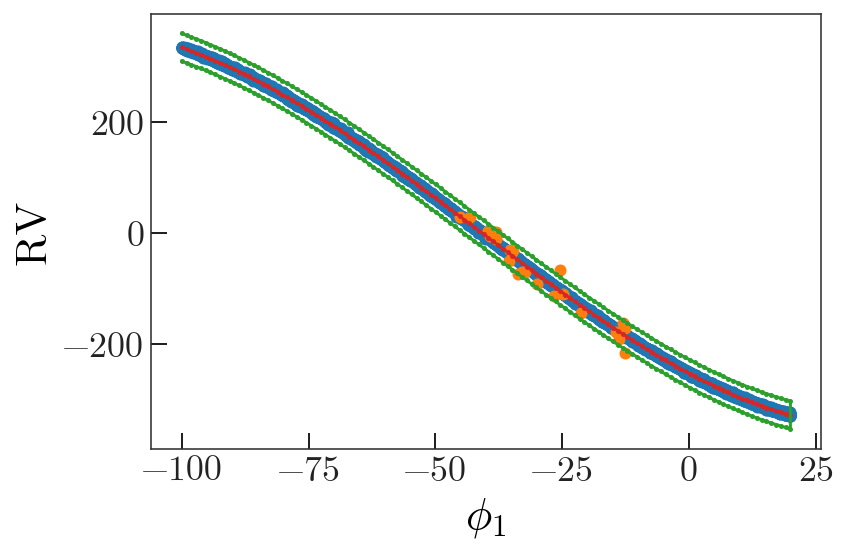

In [9]:
plt.scatter(model_phi1, model_streamc.radial_velocity)

rv_func = np.poly1d(np.polyfit(model_phi1, model_streamc.radial_velocity, deg=5))
_grid = np.linspace(-100, 20, 128)

_tmp1 = np.vstack((_grid, rv_func(_grid)-25)).T
_tmp2 = np.vstack((_grid, rv_func(_grid)+25)).T
rv_poly = np.vstack((_tmp1, _tmp2[::-1]))

plt.plot(_grid, rv_func(_grid), color='tab:red')
plt.scatter(kop_vr['phi1'], kop_vr['vr'])
plt.plot(rv_poly[:, 0], rv_poly[:, 1], color='tab:green')

plt.xlabel(r'$\phi_1$')
plt.ylabel('RV')

mpl.path.Path(rv_poly).contains_points(np.vstack((kop_vr['phi1'], kop_vr['vr'])).T).sum(), len(kop_vr)

---

# APOGEE

In [10]:
c = g.get_skycoord(distance=8*u.kpc, 
                   radial_velocity=np.array(g.VHELIO_AVG)*u.km/u.s)
gd1_c = c.transform_to(gc.GD1)

apogee_phi1 = gd1_c.phi1.wrap_at(180*u.deg)
apogee_phi2 = gd1_c.phi2

apogee_mask = ((apogee_phi1 > -100*u.deg) & (apogee_phi1 < 20*u.deg) &
               (apogee_phi2 > -10*u.deg) & (apogee_phi2 < 5*u.deg))

gd1_c = gd1_c[apogee_mask]

apogee_phi1 = gd1_c.phi1.wrap_at(180*u.deg)
apogee_phi2 = gd1_c.phi2

apogee_pm1 = gd1_c.pm_phi1_cosphi2.to(u.mas/u.yr)
apogee_pm2 = gd1_c.pm_phi2.to(u.mas/u.yr)

In [11]:
phi12_mask = mpl.patches.Path(phi12_poly).contains_points(np.vstack((apogee_phi1, apogee_phi2)).T)
pm_mask = mpl.patches.Path(pm_poly).contains_points(np.vstack((apogee_pm1, apogee_pm2)).T)
rv_mask = mpl.patches.Path(rv_poly).contains_points(np.vstack((apogee_phi1, g.VHELIO_AVG[apogee_mask])).T)
kin_mask = phi12_mask & pm_mask & rv_mask

In [12]:
phi12_mask.sum(), pm_mask.sum(), rv_mask.sum(), kin_mask.sum()

(8953, 704, 1863, 8)

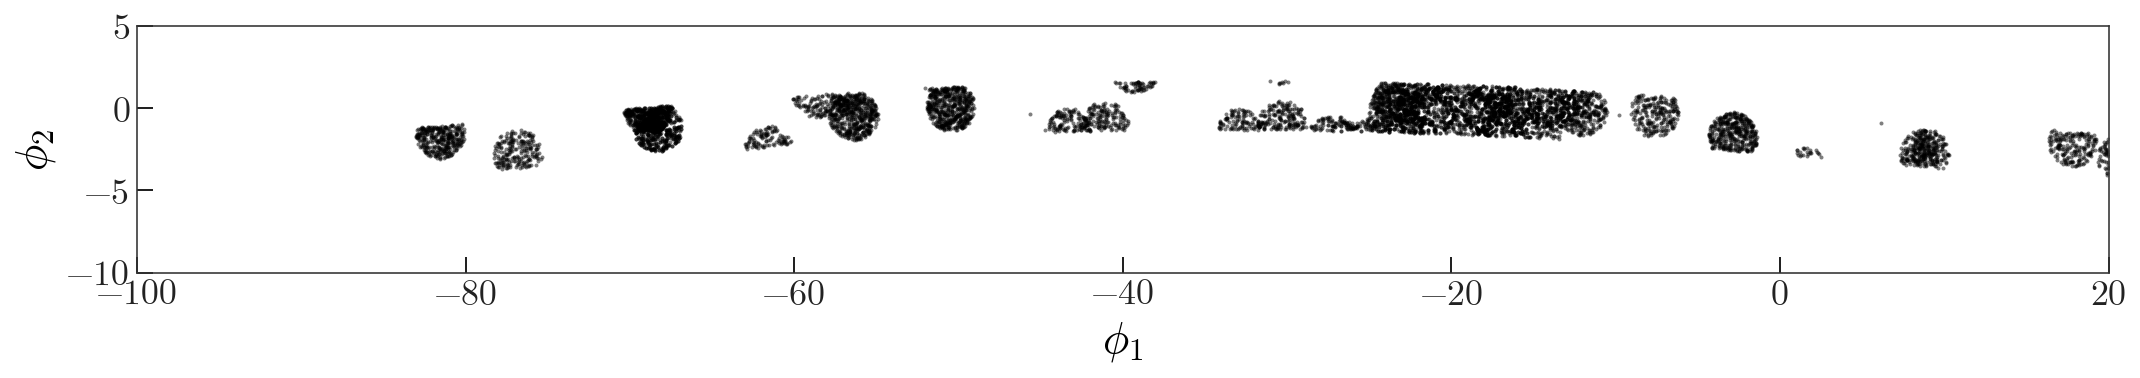

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(apogee_phi1[phi12_mask], apogee_phi2[phi12_mask], 
        marker='o', color='k', ms=2,
        ls='none', alpha=0.5)

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)
ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')

fig.tight_layout()

In [14]:
feh_mask = (g.M_H[apogee_mask] < -1) & (g.M_H[apogee_mask] > -2.5)
gd1_full_mask = kin_mask & feh_mask
gd1_full_mask.sum()

3

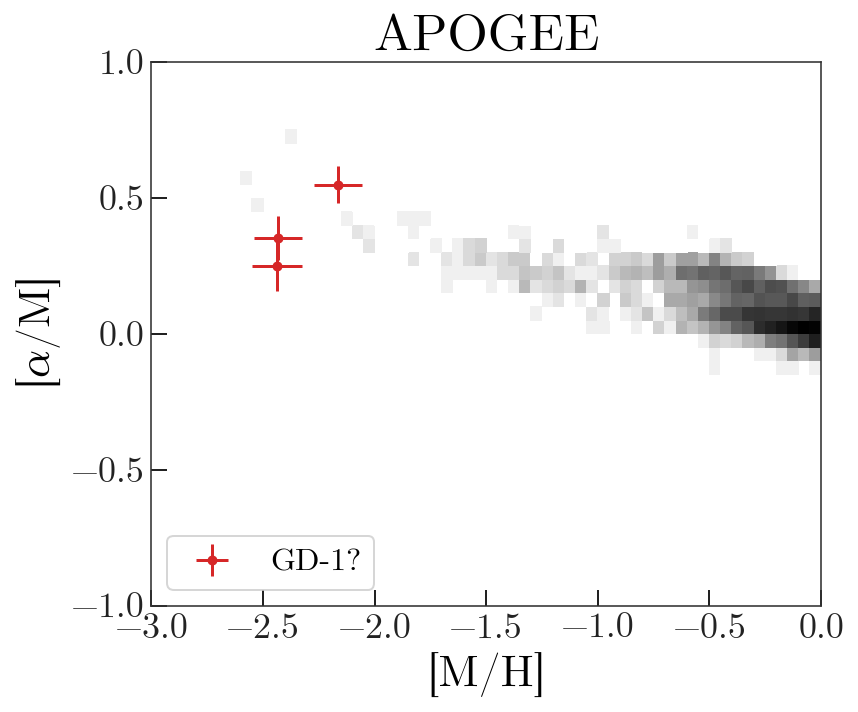

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.errorbar(g.M_H[apogee_mask][gd1_full_mask], 
            g.ALPHA_M[apogee_mask][gd1_full_mask],
            xerr=g.M_H_ERR[apogee_mask][gd1_full_mask], 
            yerr=g.ALPHA_M_ERR[apogee_mask][gd1_full_mask], 
            marker='o', ls='none', color='tab:red', 
            label='GD-1?', zorder=100)

H, xe, ye = np.histogram2d(g.M_H[apogee_mask][phi12_mask],
                           g.ALPHA_M[apogee_mask][phi12_mask],
                           bins=(np.arange(-3, 0+1e-3, 0.05),
                                 np.arange(-1, 1+1e-3, 0.05)))
ax.pcolormesh(xe, ye, H.T, cmap='Greys', zorder=-100, 
              norm=mpl.colors.LogNorm())

ax.set_xlim(-3, 0)
ax.set_ylim(-1, 1)

ax.legend(loc='lower left', fontsize=16)

ax.set_xlabel('[M/H]')
ax.set_ylabel(r'[$\alpha$/M]')

ax.set_title('APOGEE')
fig.set_facecolor('w')

### Get stars from NGC 6809 to compare:

In [16]:
ngc_c = coord.SkyCoord.from_name('NGC 6809')

In [17]:
ngc_mask = c.separation(ngc_c) < 0.5*u.deg

In [18]:
cl_mask = np.sqrt( (g.pmra.value - -3.404)**2 + (g.pmdec.value - -9.265)**2 ) < 0.7

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [19]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(g.pmra[ngc_mask], g.pmdec[ngc_mask],
#         marker='.', ls='none', alpha=0.25)
# ax.plot(g.pmra[ngc_mask & cl_mask], g.pmdec[ngc_mask & cl_mask],
#         marker='.', ls='none', alpha=1)
# ax.set_xlim(-10, -1)
# ax.set_ylim(-10, -1)
# fig.tight_layout()

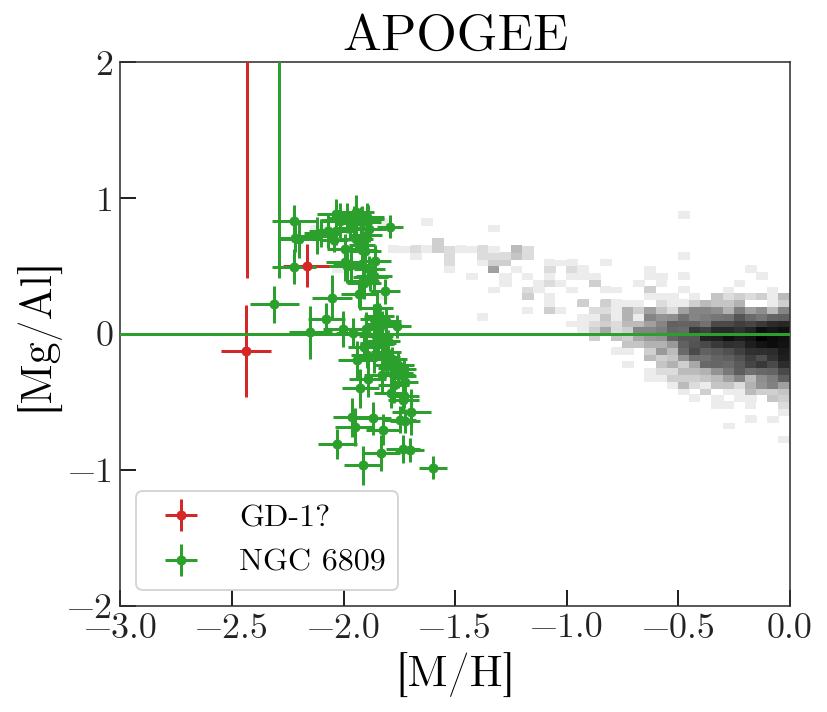

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.errorbar(g.M_H[apogee_mask][gd1_full_mask], 
            (g.MG_FE - g.AL_FE)[apogee_mask][gd1_full_mask],
            xerr=g.M_H_ERR[apogee_mask][gd1_full_mask], 
            yerr=np.sqrt(g.MG_FE_ERR**2 + g.AL_FE_ERR**2)[apogee_mask][gd1_full_mask], 
            marker='o', ls='none', color='tab:red', 
            label='GD-1?', zorder=100)


ax.errorbar(g.M_H[ngc_mask & cl_mask], 
            (g.MG_FE - g.AL_FE)[ngc_mask & cl_mask],
            xerr=g.M_H_ERR[ngc_mask & cl_mask], 
            yerr=np.sqrt(g.MG_FE_ERR**2 + g.AL_FE_ERR**2)[ngc_mask & cl_mask], 
            marker='o', ls='none', color='tab:green', 
            label='NGC 6809', zorder=100)

H, xe, ye = np.histogram2d(g.M_H[apogee_mask][phi12_mask],
                           (g.MG_FE - g.AL_FE)[apogee_mask][phi12_mask],
                           bins=(np.arange(-3, 0+1e-3, 0.05),
                                 np.arange(-2, 2+1e-3, 0.05)))
ax.pcolormesh(xe, ye, H.T, cmap='Greys', zorder=-100, 
              norm=mpl.colors.LogNorm())

ax.set_xlim(-3, 0)
ax.set_ylim(-2, 2)

ax.legend(loc='lower left', fontsize=16)

ax.set_xlabel('[M/H]')
ax.set_ylabel(r'[Mg/Al]')

ax.set_title('APOGEE')
fig.set_facecolor('w')

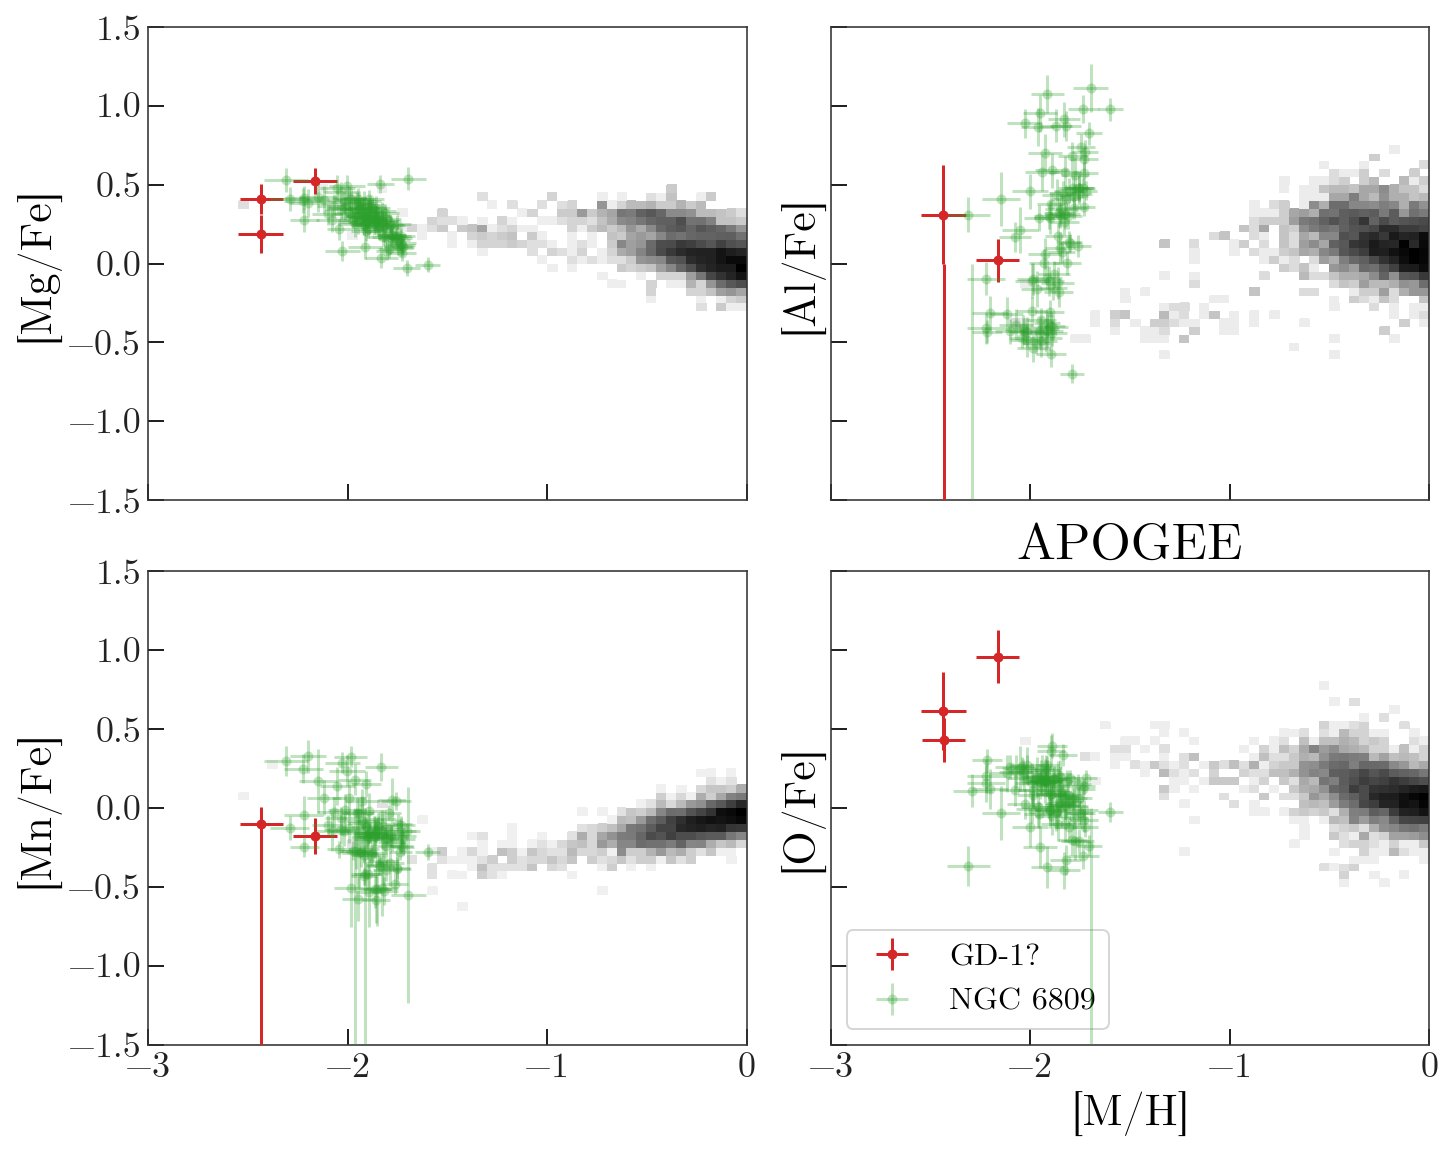

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for name, ax in zip(['MG_FE', 'AL_FE', 'MN_FE', 'O_FE'], axes.flat):
    ax.errorbar(g.M_H[apogee_mask][gd1_full_mask], 
                getattr(g, name)[apogee_mask][gd1_full_mask],
                xerr=g.M_H_ERR[apogee_mask][gd1_full_mask], 
                yerr=getattr(g, name + '_ERR')[apogee_mask][gd1_full_mask], 
                marker='o', ls='none', color='tab:red', 
                label='GD-1?', zorder=100)


    ax.errorbar(g.M_H[ngc_mask & cl_mask], 
                getattr(g, name)[ngc_mask & cl_mask],
                xerr=g.M_H_ERR[ngc_mask & cl_mask], 
                yerr=getattr(g, name+'_ERR')[ngc_mask & cl_mask], 
                marker='o', ls='none', color='tab:green', 
                label='NGC 6809', zorder=100, alpha=0.3)

    H, xe, ye = np.histogram2d(g.M_H[apogee_mask][phi12_mask],
                               getattr(g, name)[apogee_mask][phi12_mask],
                               bins=(np.arange(-3, 0+1e-3, 0.05),
                                     np.arange(-2, 2+1e-3, 0.05)))
    ax.pcolormesh(xe, ye, H.T, cmap='Greys', zorder=-100, 
                  norm=mpl.colors.LogNorm())
    
    ax.set_ylabel('[{0}/{1}]'.format(*[x.capitalize() for x in name.split('_')]))

ax.set_xlim(-3, 0)
ax.set_ylim(-1.5, 1.5)

ax.legend(loc='lower left', fontsize=16)

ax.set_xlabel('[M/H]')
# ax.set_ylabel(r'[Mg/Al]')

ax.set_title('APOGEE')
fig.set_facecolor('w')

fig.tight_layout()

---

In [39]:
gaia_g = GaiaData('/Users/adrian/projects/gd1-dr2/data/gd1-master.fits')
gaia_g = gaia_g[gaia_g.pm_mask & gaia_g.gi_cmd_mask]

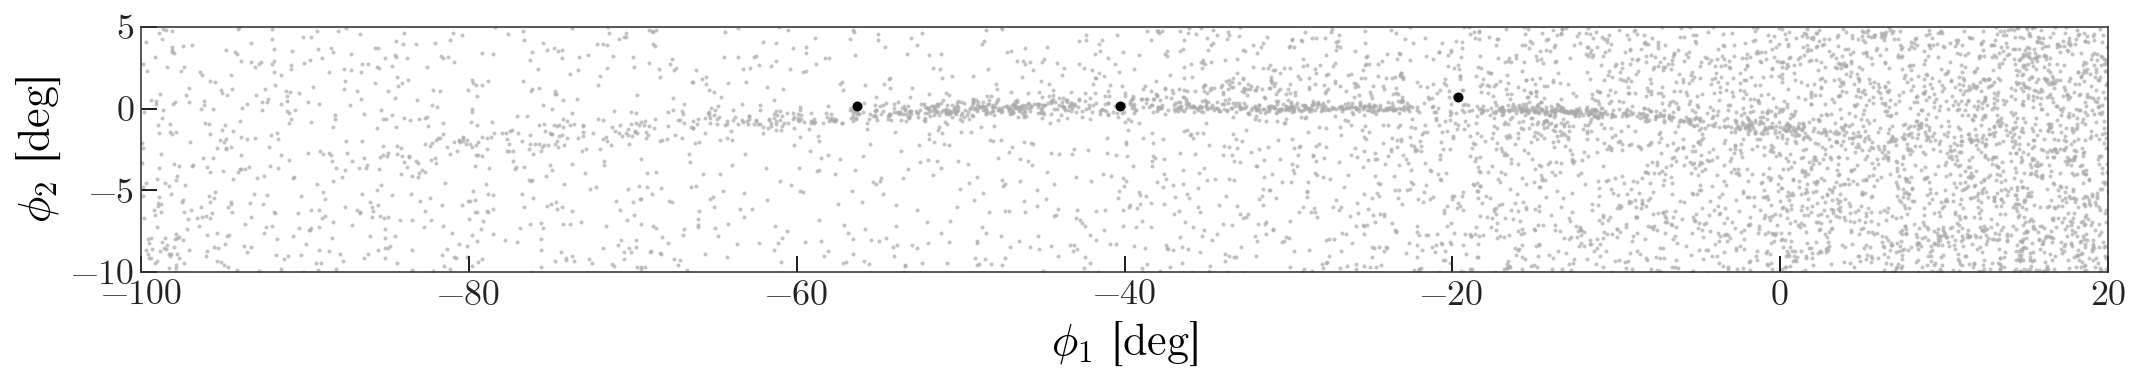

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(apogee_phi1[gd1_full_mask], 
        apogee_phi2[gd1_full_mask], 
        marker='o', color='k', ms=5,
        ls='none', alpha=1)

ax.plot(gaia_g.phi1, gaia_g.phi2, marker='o', 
        ms=2, color='#aaaaaa', alpha=0.7, 
        ls='none', zorder=-10)

ax.set_xlim(-100, 20)
ax.set_ylim(-10, 5)
ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$ [deg]')
ax.set_ylabel(r'$\phi_2$ [deg]')

fig.tight_layout()